In [1]:
#!/usr/bin/env python
# encoding: utf-8
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator

gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=800)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
# from xgboost import XGBClassifier
import tensorflow.keras.backend as K
from sklearn import metrics

# Import local libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import importlib
import os


print("Tensorflow Version is {}".format(tf.__version__))
print("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.device('/device:XLA_GPU:0')
!nvidia-smi

1 Physical GPUs, 1 Logical GPU
Tensorflow Version is 2.0.0
Keras Version is 2.2.4-tf
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10561113245175657234
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14590781576504216573
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2955781155829293608
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 838860800
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 13463429060890050494
physical_device_desc: "device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:84:00.0, compute capability: 6.0"
]
Wed Dec  2 14:19:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 10.1     |

In [2]:
# Take in a tuple of image lists, normalze and zero zenter all of them.
def Get_average_var(image_lists):
    
    image_lists = image_lists.reshape(image_lists.shape[0], 40 ,40)
    tmp_av = np.average(image_lists, axis=0)
    tmp_var = np.var(image_lists, axis=0)
    
    return tmp_av, tmp_var

def zero_center_and_normalize(image_lists, average, var):
    image_lists = image_lists.reshape(image_lists.shape[0], 40 ,40)
    for i, element in enumerate(image_lists):
        image_lists[i] = np.divide((element - average), (np.sqrt(var)+1e-5)) #perhaps add some r to temp_sd to suppress noise
    image_lists = image_lists.reshape(image_lists.shape[0], 40 ,40, 1)
    
    return image_lists



#  CNN for jet images

In [3]:
# preprocess = "trimmed"
preprocess = "untrimmed"
standardlization = 1 #1 for True #0 for False 

HOMEPATH = "/dicos_ui_home/alanchung/UniversalityDNN/"

if standardlization:
    
    if os.path.exists(HOMEPATH + "Data_ML/CNN_2CNN" + "_" + str(preprocess) + "_std") == 0:
        os.mkdir(HOMEPATH + "Data_ML/CNN_2CNN" + "_" + str(preprocess) + "_std")
        datapath = HOMEPATH + "Data_ML/"
        savepath = HOMEPATH + "Data_ML/CNN_2CNN" + "_" + str(preprocess) + "_std/"
    else: 
        datapath = HOMEPATH + "Data_ML/"
        savepath = HOMEPATH + "Data_ML/CNN_2CNN" + "_" + str(preprocess) + "_std/"
        
        
    av = np.load(HOMEPATH + "average" + "_" + str(preprocess) + ".npy")
    var = np.load(HOMEPATH + "variance" + "_" + str(preprocess) + ".npy")

           
else:
        
    if os.path.exists(HOMEPATH + "Data_ML/CNN_2CNN" + "_" + str(preprocess)) == 0:
        os.mkdir(HOMEPATH + "Data_ML/CNN_2CNN" + "_" + str(preprocess))
        datapath = HOMEPATH + "Data_ML/"
        savepath = HOMEPATH + "Data_ML/CNN_2CNN" + "_" + str(preprocess) + "/"
    else: 
        datapath = HOMEPATH + "Data_ML/"
        savepath = HOMEPATH + "Data_ML/CNN_2CNN" + "_" + str(preprocess) + "/"
           

W = ["W_herwig_ang","W_pythia_def","W_pythia_vin","W_pythia_dip","W_sherpa_def"]
QCD = [ "QCD_herwig_ang","QCD_pythia_def","QCD_pythia_vin","QCD_pythia_dip","QCD_sherpa_def"]  

herwig_ang_train = np.load(datapath + "herwig_ang_train" + "_" + str(preprocess) + ".npz")["arr_0"]
herwig_ang_test = np.load(datapath + "herwig_ang_test" + "_" + str(preprocess) + ".npz")["arr_0"]
herwig_ang_val = np.load(datapath + "herwig_ang_val" + "_" + str(preprocess) + ".npz")["arr_0"]

pythia_def_train = np.load(datapath + "pythia_def_train" + "_" + str(preprocess) + ".npz")["arr_0"]
pythia_def_test = np.load(datapath + "pythia_def_test" + "_" + str(preprocess) + ".npz")["arr_0"]
pythia_def_val = np.load(datapath + "pythia_def_val" + "_" + str(preprocess) + ".npz")["arr_0"]

pythia_vin_train = np.load(datapath + "pythia_vin_train" + "_" + str(preprocess) + ".npz")["arr_0"]
pythia_vin_test = np.load(datapath + "pythia_vin_test" + "_" + str(preprocess) + ".npz")["arr_0"]
pythia_vin_val = np.load(datapath + "pythia_vin_val" + "_" + str(preprocess) + ".npz")["arr_0"]

pythia_dip_train = np.load(datapath + "pythia_dip_train" + "_" + str(preprocess) + ".npz")["arr_0"]
pythia_dip_test = np.load(datapath + "pythia_dip_test" + "_" + str(preprocess) + ".npz")["arr_0"]
pythia_dip_val = np.load(datapath + "pythia_dip_val" + "_" + str(preprocess) + ".npz")["arr_0"]

sherpa_def_train = np.load(datapath + "sherpa_def_train" + "_" + str(preprocess) + ".npz")["arr_0"]
sherpa_def_test = np.load(datapath + "sherpa_def_test" + "_" + str(preprocess) + ".npz")["arr_0"]
sherpa_def_val = np.load(datapath + "sherpa_def_val" + "_" + str(preprocess) + ".npz")["arr_0"]

ntrain = int(len(herwig_ang_train)/2.)
ntest = int(len(herwig_ang_test)/2.)
nval = int(len(herwig_ang_val)/2.)
y_train = np.concatenate((np.full(ntrain, 1), np.full(ntrain, 0)))
y_test = np.concatenate((np.full(ntest, 1), np.full(ntest, 0)))
y_val = np.concatenate((np.full(nval, 1), np.full(nval, 0)))

if standardlization:
    herwig_ang_train = zero_center_and_normalize(herwig_ang_train, av, var)
    herwig_ang_test = zero_center_and_normalize(herwig_ang_test, av, var)
    herwig_ang_val = zero_center_and_normalize(herwig_ang_val, av, var)

    pythia_def_train = zero_center_and_normalize(pythia_def_train, av, var)
    pythia_def_test = zero_center_and_normalize(pythia_def_test, av, var)
    pythia_def_val = zero_center_and_normalize(pythia_def_val, av, var)

    pythia_vin_train = zero_center_and_normalize(pythia_vin_train, av, var)
    pythia_vin_test = zero_center_and_normalize(pythia_vin_test, av, var)
    pythia_vin_val = zero_center_and_normalize(pythia_vin_val, av, var)

    pythia_dip_train = zero_center_and_normalize(pythia_dip_train, av, var)
    pythia_dip_test = zero_center_and_normalize(pythia_dip_test, av, var)
    pythia_dip_val = zero_center_and_normalize(pythia_dip_val, av, var)

    sherpa_def_train = zero_center_and_normalize(sherpa_def_train, av, var)
    sherpa_def_test = zero_center_and_normalize(sherpa_def_test, av, var)
    sherpa_def_val = zero_center_and_normalize(sherpa_def_val, av, var)


CNN_Model = ["herwig_ang", "pythia_def", "pythia_vin", "pythia_dip", "sherpa_def"]
CNN_model_name = ["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Sherpa Default"]


XTRAIN = [herwig_ang_train,pythia_def_train,
         pythia_vin_train,pythia_dip_train,
         sherpa_def_train]

YTRAIN = [y_train,y_train,y_train,y_train,y_train]


XVAL = [herwig_ang_val,pythia_def_val,
         pythia_vin_val,pythia_dip_val,
         sherpa_def_val]

YVAL = [y_val,y_val,y_val,y_val,y_val]


XTEST = [herwig_ang_test,pythia_def_test,
         pythia_vin_test,pythia_dip_test,
         sherpa_def_test]

YTEST = [y_test,y_test,y_test,y_test,y_test]


print("W jet : QCD jet = 1 : 1")
print("\r")
print("{:^8}{:^15}{:^15}{:^15}{:^15}{:^15}".format("","Herwig Angular","Pythia Default","Pythia Vincia","Pythia Dipole","Sherpa Default"))
print("{:^8}{:^15}{:^15}{:^15}{:^15}{:^15}".format("Train #",len(herwig_ang_train),len(pythia_def_train),len(pythia_vin_train),len(pythia_dip_train),len(sherpa_def_train)))
print("{:^8}{:^15}{:^15}{:^15}{:^15}{:^15}".format("Test #",len(herwig_ang_test),len(pythia_def_test),len(pythia_vin_test),len(pythia_dip_test),len(sherpa_def_test)))
print("{:^8}{:^15}{:^15}{:^15}{:^15}{:^15}".format("Val. #",len(herwig_ang_val),len(pythia_def_val),len(pythia_vin_val),len(pythia_dip_val),len(sherpa_def_val)))


W jet : QCD jet = 1 : 1

        Herwig Angular Pythia Default  Pythia Vincia  Pythia Dipole Sherpa Default 
Train #     101222         101222         101222         101222         101222     
 Test #      12652          12652          12652          12652          12652     
 Val. #      12652          12652          12652          12652          12652     


In [4]:
# # Take in a tuple of image lists, normalze and zero zenter all of them.
# def zero_center_and_normalize(image_lists):
#     tmp_av = np.average(image_lists, axis=0)
#     tmp_sd = np.std(image_lists, axis=0)
#     for i, element in enumerate(image_lists):
#         image_lists[i] = np.divide((element - tmp_av), (tmp_sd+1e-5)) #perhaps add some r to temp_sd to suppress noise
#     return image_lists

In [5]:
######################################################################################
# time counter
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
############################################################################################################################################################
CNN = 0
for i, filename in enumerate(os.listdir(savepath)):
#         if filename == CNN_Model[i]+"_CNN.h5" :
        if filename[-6:] == "CNN.h5" :
            CNN += 1 
            
if CNN == 0:

    for i, element in enumerate(CNN_Model[:1]):

        model_jet = Sequential(name = "Sequential_for_CNN_2CNN_"+str(CNN_Model[i]))
        input_shape = (40, 40, 1)
        # model_jet.add(keras.Input(shape=input_shape, name = 'input'))
        # model_jet.add(keras.Input(shape=input_shape, name = 'input'))
        model_jet.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                         activation='relu',
        #                 data_format='channels_first',
        #                 input_shape=input_shape, 
                        input_shape=(40, 40, 1),
                        name = 'jet'))
        model_jet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
        #                            data_format='channels_first', 
                                   name = 'jet_MaxPooling_1'))
        model_jet.add(Conv2D(64, (5, 5), activation='relu',
        #                      data_format='channels_first', 
                             name = 'jet_2D_1'))
        model_jet.add(MaxPooling2D(pool_size=(2, 2),
        #                            data_format='channels_first', 
                                   name = 'jet_MaxPooling_2'))
        model_jet.add(Flatten(name = 'jet_flatten'))
        model_jet.add(Dense(300, activation='relu', name = 'jet_dense_1'))

        model_jet.add(Dropout(0.1))
        model_jet.add(Dense(1, activation='sigmoid', name = 'jet_dense_2'))

        # mergedOut = Concatenate()([model_event.output,model_jet.output])
        # mergedOut = Dense(1, activation='sigmoid')(mergedOut)
        # # mergedOut = Dense(4, activation='softmax')(mergedOut)

        # newModel = Model([model_event.input,model_jet.input], mergedOut,name = 'Combined')


        model_opt = keras.optimizers.Adadelta()

        model_jet.compile(loss="binary_crossentropy",#keras.losses.
                      optimizer=model_opt,
                      metrics=['accuracy'])
        model_jet.summary()

        ######################################################################################
        # time counter
        print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
        ticks_2 = time.time()
        ############################################################################################################################################################


        check_list=[]
        csv_logger = CSVLogger(savepath + CNN_Model[i] + "_training_log.csv")
        checkpoint = ModelCheckpoint(
                            filepath= savepath + CNN_Model[i] + "_checkmodel.h5",
                            save_best_only=True,
                            verbose=0)

        check_list.append(checkpoint)
        check_list.append(csv_logger)
        model_jet.fit(np.asarray(XTRAIN[i]), np.asarray(YTRAIN[i]),
                        validation_data = (np.asarray(XVAL[i]), np.asarray(YVAL[i])),
                        batch_size=256,
                        epochs=500,
                        shuffle=True,
                        callbacks=check_list,
                        verbose=0)

        model_jet.save(savepath + CNN_Model[i] + "_CNN.h5")

        ############################################################################################################################################################
        ticks_3 = time.time()
        totaltime =  ticks_3 - ticks_2
        print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

if CNN == 5:
    print("We have prepared models !!")
        

############################################################################################################################################################
ticks_4 = time.time()
totaltime =  ticks_4 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))


Wed Dec 02 14:20:15 2020
We have prepared models !!
Time Cost : 0.0000 min


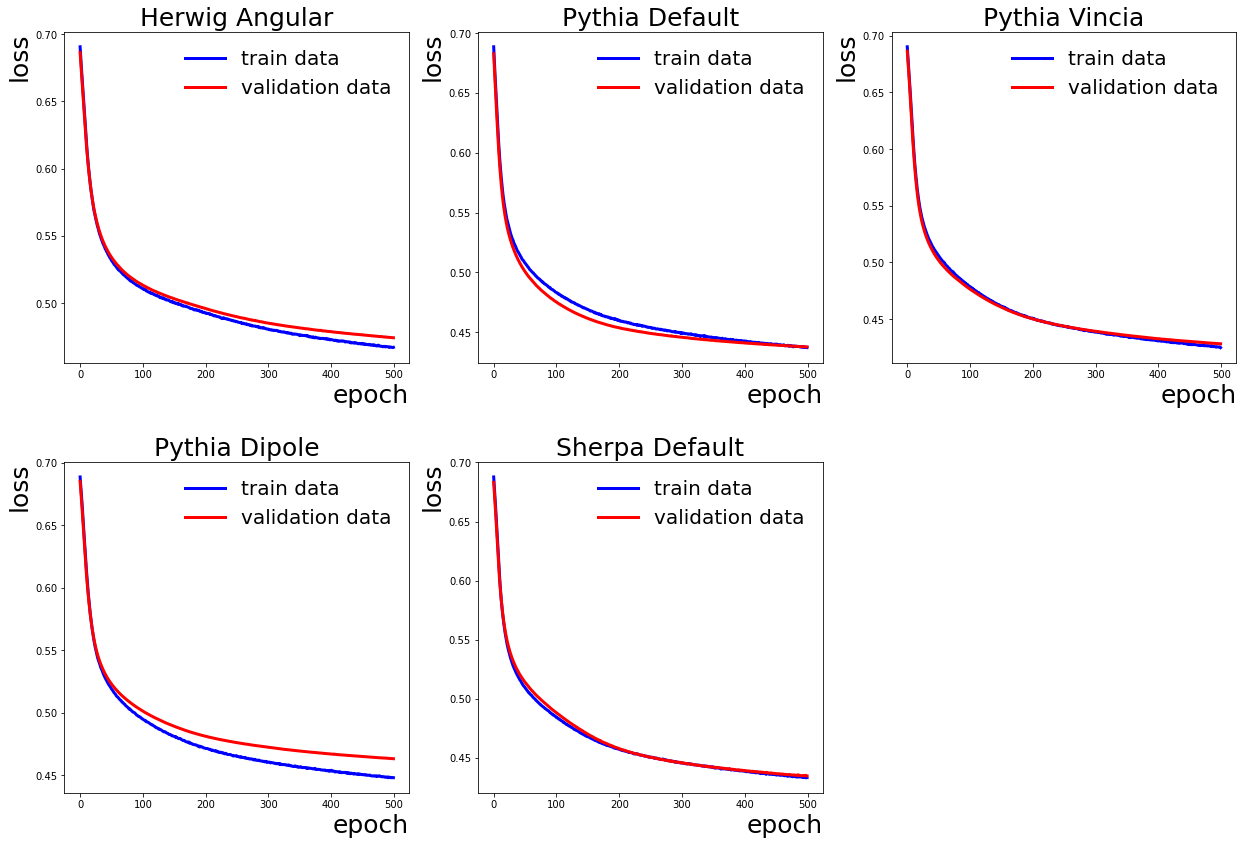

In [6]:
# Import local libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import importlib
import os

# HOMEPATH = "/dicos_ui_home/alanchung/UniversalityDNN/"
# Data_High_Level_Features_path =  HOMEPATH + "Data_High_Level_Features/"
# savepath = HOMEPATH + "Data_ML/CNN_2CNN_untrimmed_std/"

CNN_Model = ["herwig_ang", "pythia_def", "pythia_vin", "pythia_dip", "sherpa_def"]
CNN_model_name = ["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Sherpa Default"]

plt.figure(figsize=(21,14))
for i, model in enumerate(CNN_Model):
    plot_axis = plt.subplot(2,3,i+1)
    
#     fig.subplots_adjust(bottom=0.18, left=0.18, top=0.95, right=0.95)
    LOSS = pd.read_csv(savepath + model + "_training_log.csv")

#     plt.tick_params(which='both', width=2)
#     plt.tick_params(which='major', length=8)
#     plt.tick_params(which='minor', length=4, color='k')
    plot_axis.plot(LOSS["loss"], label='train data',c='blue',linewidth = 3)
    plot_axis.plot(LOSS["val_loss"], label='validation data',c='red',linewidth = 3)

    plt.title(CNN_model_name[i], fontsize=25)

    plot_axis.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
    plot_axis.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
    plot_axis.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

#     plt.tick_params(which='minor',width=0)
#     plt.tick_params(labelsize=25)
    # plt.savefig("./Figures/learning_curve_w_noise.pdf", transparent=True)
    
#     plot_axis.set_ylim((0,0.01))
#     plot_axis.set_xlim((400,500))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

In [7]:
AUC = np.zeros((5,5))
max_sig = np.zeros((5,5))
r05 = np.zeros((5,5))

for i, model in enumerate(CNN_Model):
#     print(model)
    for j, test_generator in enumerate(XTEST):
        
        CNN = load_model(savepath + CNN_Model[i] + "_CNN.h5")

        prediction_CNN_test = CNN.predict(np.asarray(test_generator))

        discriminator_test = prediction_CNN_test

        discriminator_test = discriminator_test/(max(discriminator_test))

        AUC[i,j] = metrics.roc_auc_score(YTEST[i],discriminator_test)
        FalsePositiveFull, TruePositiveFull, _ = metrics.roc_curve(YTEST[i],discriminator_test)
#         print(FalsePositiveFull_GBDT_test[10:], TruePositiveFull_GBDT_test[10:])
#         print(len(FalsePositiveFull),len(TruePositiveFull),len(YTEST[i]))
        aaa = np.where(TruePositiveFull > 0.1)
        max_sig[i,j] = max(TruePositiveFull[aaa]/np.sqrt(FalsePositiveFull[aaa]))
        bbb = np.where(TruePositiveFull >= 0.5)
        r05[i,j] = 1./FalsePositiveFull[bbb[0][0]]

print("Models are trained by row and test to column.")
print("Performance in AUC")
print("\r")
print("{:^15}{:^15}{:^15}{:^15}{:^15}{:^15}".format("","Herwig Angular","Pythia Default","Pythia Vincia","Pythia Dipole","Sherpa Default"))
for i in range(5):
    print("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format(CNN_model_name[i],AUC[i,0], AUC[i,1], AUC[i,2], AUC[i,3], AUC[i,4]))
print("\r")
print("Performance in Max Significance")
print("\r")
for i in range(5):
    print("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format(CNN_model_name[i],max_sig[i,0], max_sig[i,1], max_sig[i,2], max_sig[i,3], max_sig[i,4]))
print("\r")
print("1/fpr @ tpr = 0.5 (rejection at 50% signal efficiency)")
print("\r")
for i in range(5):
    print("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format(CNN_model_name[i],r05[i,0], r05[i,1], r05[i,2], r05[i,3], r05[i,4]))




Models are trained by row and test to column.
Performance in AUC

               Herwig Angular Pythia Default  Pythia Vincia  Pythia Dipole Sherpa Default 
Herwig Angular      0.842          0.870          0.865          0.854          0.867     
Pythia Default      0.840          0.873          0.870          0.857          0.869     
 Pythia Vincia      0.840          0.874          0.871          0.859          0.870     
 Pythia Dipole      0.838          0.872          0.869          0.857          0.868     
Sherpa Default      0.841          0.873          0.871          0.857          0.870     

Performance in Max Significance

Herwig Angular      3.842          4.443          5.278          5.061          4.052     
Pythia Default      4.322          4.789          5.058          4.701          3.961     
 Pythia Vincia      3.704          4.564          4.619          4.711          4.020     
 Pythia Dipole      3.593          4.403          4.763          4.245          3

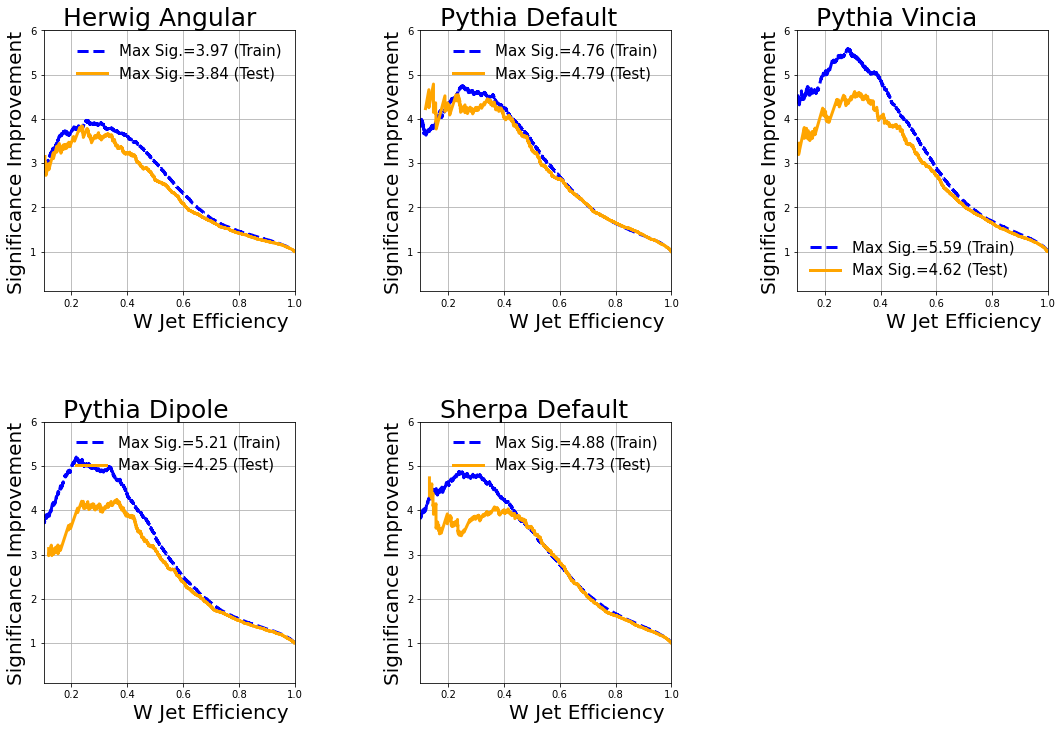

In [13]:
axis = 1
if axis == 0:
    process = "QCD"
elif axis == 1:
    process = "W Jet"

plt.figure(figsize=(18,12))
for i, model in enumerate(CNN_Model):
    plot_axis = plt.subplot(2,3,i+1)

    CNN = load_model(savepath + CNN_Model[i] + "_CNN.h5")

    prediction_CNN_test = CNN.predict_proba(XTEST[i])
    prediction_CNN_train = CNN.predict_proba(XTRAIN[i])

    discriminator_test = prediction_CNN_test
    discriminator_train = prediction_CNN_train

    discriminator_test = discriminator_test/(max(discriminator_test))
    discriminator_train = discriminator_train/(max(discriminator_train))
    


    test_auc_CNN_test = metrics.roc_auc_score(YTEST[i],discriminator_test)
    FalsePositiveFull_CNN_test, TruePositiveFull_CNN_test, _ = metrics.roc_curve(YTEST[i],discriminator_test)

    train_auc_CNN_train = metrics.roc_auc_score(YTRAIN[i],discriminator_train)
    FalsePositiveFull_CNN_train, TruePositiveFull_CNN_train, _ = metrics.roc_curve(YTRAIN[i],discriminator_train)
 
    a = np.where(TruePositiveFull_CNN_test > 0.1)
    b = np.where(TruePositiveFull_CNN_train > 0.1)
#     plt.plot(TruePositiveFull_CNN_test,1-FalsePositiveFull_CNN_test,"-", color='orange', linewidth = 3, label='AUC={0:.2f} (Test)'.format(test_auc_CNN_test))
    max_sig_test = max(TruePositiveFull_CNN_test[a]/np.sqrt(FalsePositiveFull_CNN_test[a]))
    max_sig_train = max(TruePositiveFull_CNN_train[b]/np.sqrt(FalsePositiveFull_CNN_train[b]))
    plt.plot(TruePositiveFull_CNN_train[b],TruePositiveFull_CNN_train[b]/np.sqrt(FalsePositiveFull_CNN_train[b]),"--", color='b', linewidth = 3, label='Max Sig.={0:.2f} (Train)'.format(max_sig_train))
    plt.plot(TruePositiveFull_CNN_test[a],TruePositiveFull_CNN_test[a]/np.sqrt(FalsePositiveFull_CNN_test[a]),"-", color='orange', linewidth = 3, label='Max Sig.={0:.2f} (Test)'.format(max_sig_test))

# plt.scatter(0.75,1./0.32, marker="D", s=300 , c='b')
# plt.scatter(0.70,1./0.13, marker="D", s=300 , c='orange')

    plot_axis.set_xlim((0.1,1))
    plot_axis.set_ylim((0.1,6))
    # plt.yscale("log")
    plt.xlim((0.1,1))
#     plt.ylim((1, 1E+4))
#     plt.yscale("log")
#     plot_axis.set_tick_params(axis='x', labelsize=25)
#     plot_axis.set_tick_params(axis='y', labelsize=25)
    # ax.yaxis.set_major_locator(MaxNLocator(5))
    # ax.xaxis.set_major_locator(MaxNLocator(5))
    plot_axis.set_xlabel(str(process)+' Efficiency ', fontsize=20,horizontalalignment='right',x=1)
    plot_axis.set_ylabel('Significance Improvement', fontsize=20,horizontalalignment='right',y=1)
    plot_axis.legend(ncol=1,fontsize=15, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
#     plt.tight_layout()
    plot_axis.text(x=0.17, y=6.1, s=str(CNN_model_name[i]),fontsize=25) 

    plot_axis.set_xlim((0.1,1))
#     plot_axis.set_ylim((1, 2E+2))
#     plot_axis.set_yscale("log")
    plot_axis.grid()
# plt.savefig("./Higgs_Pt/Comparison_ROC.pdf", transparent=True)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWar

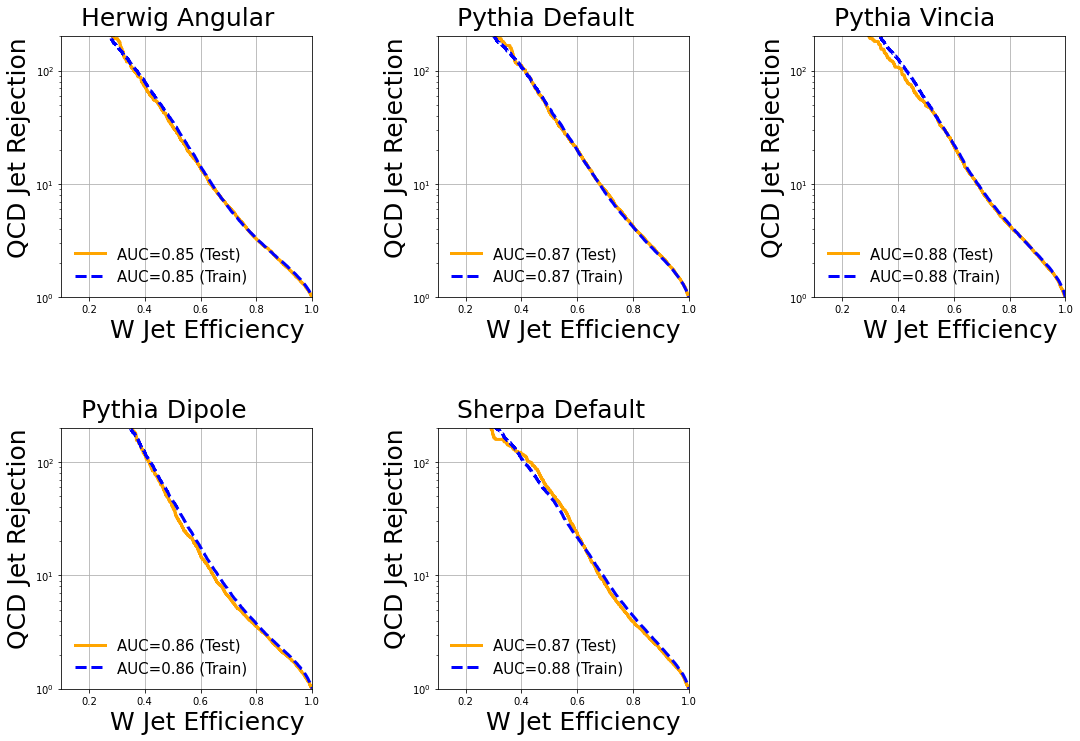

In [9]:
axis = 1
if axis == 0:
    process = "QCD"
elif axis == 1:
    process = "W Jet"

plt.figure(figsize=(18,12))
for i, model in enumerate(CNN_Model):
    plot_axis = plt.subplot(2,3,i+1)

    CNN = load_model(savepath + CNN_Model[i] + "_CNN.h5")

    prediction_CNN_test = CNN.predict_proba(XTEST[i])
    prediction_CNN_train = CNN.predict_proba(XTRAIN[i])


    discriminator_test = prediction_CNN_test
    discriminator_train = prediction_CNN_train

    discriminator_test = discriminator_test/(max(discriminator_test))
    discriminator_train = discriminator_train/(max(discriminator_train))
    


    test_auc_CNN_test = metrics.roc_auc_score(YTEST[i],discriminator_test)
    FalsePositiveFull_CNN_test, TruePositiveFull_CNN_test, _ = metrics.roc_curve(YTEST[i],discriminator_test)

    train_auc_CNN_train = metrics.roc_auc_score(YTRAIN[i],discriminator_train)
    FalsePositiveFull_CNN_train, TruePositiveFull_CNN_train, _ = metrics.roc_curve(YTRAIN[i],discriminator_train)

#     plt.plot(TruePositiveFull_CNN_test,1-FalsePositiveFull_CNN_test,"-", color='orange', linewidth = 3, label='AUC={0:.2f} (Test)'.format(test_auc_CNN_test))
#     plt.plot(TruePositiveFull_CNN_train,1-FalsePositiveFull_CNN_train,"--", color='b', linewidth = 3, label='AUC={0:.2f} (Train)'.format(train_auc_CNN_train))
    plt.plot(TruePositiveFull_CNN_test,1./FalsePositiveFull_CNN_test,"-", color='orange', linewidth = 3, label='AUC={0:.2f} (Test)'.format(test_auc_CNN_test))
    plt.plot(TruePositiveFull_CNN_train,1./FalsePositiveFull_CNN_train,"--", color='b', linewidth = 3, label='AUC={0:.2f} (Train)'.format(train_auc_CNN_train))



# plt.scatter(0.75,1./0.32, marker="D", s=300 , c='b')
# plt.scatter(0.70,1./0.13, marker="D", s=300 , c='orange')

#     plot_axis.set_xlim((0,1))
#     plot_axis.set_ylim((0,1))
    # plt.yscale("log")
    plt.xlim((0,1))
    plt.ylim((1, 1E+4))
    plt.yscale("log")
#     plot_axis.set_tick_params(axis='x', labelsize=25)
#     plot_axis.set_tick_params(axis='y', labelsize=25)
    # ax.yaxis.set_major_locator(MaxNLocator(5))
    # ax.xaxis.set_major_locator(MaxNLocator(5))
    plot_axis.set_xlabel(str(process)+' Efficiency ', fontsize=25,horizontalalignment='right',x=1)
    plot_axis.set_ylabel('QCD Jet Rejection', fontsize=25,horizontalalignment='right',y=1)
    plot_axis.legend(ncol=1,fontsize=15, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
#     plt.tight_layout()
    plot_axis.text(x=0.17, y=2.5E+2, s=str(CNN_model_name[i]),fontsize=25) 

    plot_axis.set_xlim((0.1,1))
    plot_axis.set_ylim((1, 2E+2))
    plot_axis.set_yscale("log")
    plot_axis.grid()
# plt.savefig("./Higgs_Pt/Comparison_ROC.pdf", transparent=True)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


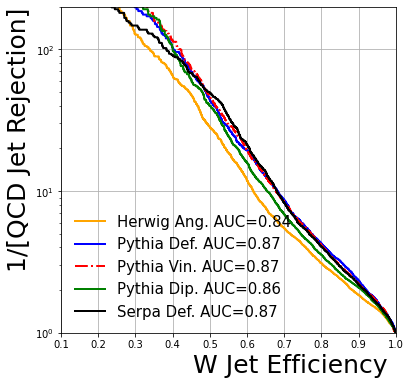

In [9]:
axis = 1
if axis == 0:
    process = "QCD"
elif axis == 1:
    process = "W Jet"

plt.figure(figsize=(6,6))

CNN = load_model(savepath + CNN_Model[1] + "_CNN.h5")

prediction_CNN_herwig_ang = CNN.predict_proba(XTEST[0])
prediction_CNN_pythia_def = CNN.predict_proba(XTEST[1])
prediction_CNN_pythia_vin= CNN.predict_proba(XTEST[2])
prediction_CNN_pythia_dip = CNN.predict_proba(XTEST[3])
prediction_CNN_sherpa_def = CNN.predict_proba(XTEST[4])


# discriminator_test = discriminator_test/(max(discriminator_test))
# discriminator_train = discriminator_train/(max(discriminator_train))
    


test_auc_herwig_ang = metrics.roc_auc_score(YTEST[0],prediction_CNN_herwig_ang)
FalsePositiveFull_herwig_ang, TruePositiveFull_herwig_ang, _ = metrics.roc_curve(YTEST[0],prediction_CNN_herwig_ang)

test_auc_pythia_def = metrics.roc_auc_score(YTEST[1],prediction_CNN_pythia_def)
FalsePositiveFull_pythia_def, TruePositiveFull_pythia_def, _ = metrics.roc_curve(YTEST[1],prediction_CNN_pythia_def)

test_auc_pythia_vin = metrics.roc_auc_score(YTEST[2],prediction_CNN_pythia_vin)
FalsePositiveFull_pythia_vin, TruePositiveFull_pythia_vin, _ = metrics.roc_curve(YTEST[2],prediction_CNN_pythia_vin)

test_auc_pythia_dip = metrics.roc_auc_score(YTEST[3],prediction_CNN_pythia_dip)
FalsePositiveFull_pythia_dip, TruePositiveFull_pythia_dip, _ = metrics.roc_curve(YTEST[3],prediction_CNN_pythia_dip)

test_auc_sherpa_def = metrics.roc_auc_score(YTEST[4],prediction_CNN_sherpa_def)
FalsePositiveFull_sherpa_def, TruePositiveFull_sherpa_def, _ = metrics.roc_curve(YTEST[4],prediction_CNN_sherpa_def)

#     plt.plot(TruePositiveFull_CNN_test,1-FalsePositiveFull_CNN_test,"-", color='orange', linewidth = 3, label='AUC={0:.2f} (Test)'.format(test_auc_CNN_test))
#     plt.plot(TruePositiveFull_CNN_train,1-FalsePositiveFull_CNN_train,"--", color='b', linewidth = 3, label='AUC={0:.2f} (Train)'.format(train_auc_CNN_train))
plt.plot(TruePositiveFull_herwig_ang,1./FalsePositiveFull_herwig_ang,"-", color='orange', linewidth = 2, label='Herwig Ang. AUC={0:.2f}'.format(test_auc_herwig_ang))
plt.plot(TruePositiveFull_pythia_def,1./FalsePositiveFull_pythia_def,"-", color='b', linewidth = 2, label='Pythia Def. AUC={0:.2f}'.format(test_auc_pythia_def))
plt.plot(TruePositiveFull_pythia_vin,1./FalsePositiveFull_pythia_vin,"-.", color='r', linewidth = 2, label='Pythia Vin. AUC={0:.2f}'.format(test_auc_pythia_vin))
plt.plot(TruePositiveFull_pythia_dip,1./FalsePositiveFull_pythia_dip,"-", color='g', linewidth = 2, label='Pythia Dip. AUC={0:.2f}'.format(test_auc_pythia_dip))
plt.plot(TruePositiveFull_sherpa_def,1./FalsePositiveFull_sherpa_def,"-", color='k', linewidth = 2, label='Serpa Def. AUC={0:.2f}'.format(test_auc_sherpa_def))

# plt.scatter(0.75,1./0.32, marker="D", s=300 , c='b')
# plt.scatter(0.70,1./0.13, marker="D", s=300 , c='orange')


plt.xlim((0.1,1))
plt.ylim((1, 2E+2))
plt.yscale("log")
#     plot_axis.set_tick_params(axis='x', labelsize=25)
#     plot_axis.set_tick_params(axis='y', labelsize=25)
    # ax.yaxis.set_major_locator(MaxNLocator(5))
    # ax.xaxis.set_major_locator(MaxNLocator(5))
plt.xlabel(str(process)+' Efficiency ', fontsize=25,horizontalalignment='right',x=1)
plt.ylabel('1/[QCD Jet Rejection]', fontsize=25,horizontalalignment='right',y=1)
plt.legend(ncol=1,fontsize=15, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
#     plt.tight_layout()
# plt.text(x=0.17, y=1.03, s=str(CNN_model_name[i]),fontsize=25) 
plt.grid()
# plt.savefig("./Higgs_Pt/Comparison_ROC.pdf", transparent=True)
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()